# Task 2

The second task is about classifying handwritten digits. We will use the MNIST dataset for training and testing. The point of this task is to develop a multi-layer neural network for classification using mostly Numpy:
* Implement sigmoid and relu layers (with forward and backward pass) 
* Implement a softmax output layer 
* Implement a fully parameterizable neural network (number and types of layers, number  of units) 
* Implement an optimizer (e.g. SGD or Adam) and a stopping criterion of your choosing 
* Train your Neural Network using backpropagation.

Evaluate different neural network architectures and compare your different results. You can also compare with the results presented in http://yann.lecun.com/exdb/mnist/


### Loading the Data Set

We will use Pytorch's torchvision module to load the MNIST dataset.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import util

In [2]:
# Downloading MNIST
# Resources used:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# https://pytorch.org/docs/stable/torchvision/datasets.html#mnist

transform = transforms.Compose(
    [transforms.ToTensor()])

#Transet is the entire train set... each item is a 2-tuple, containing an tensor (numeric rep of image) and the target value (int)
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)


Size of Train set is 60000
Size of Test set is 10000

Image depicts the target: 5


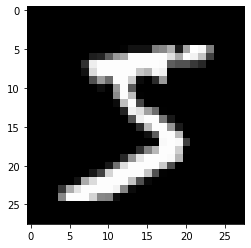

In [3]:
def display_image(image_pos=0, set=trainset):
    # First image's tensor accessed by set[0][0], its shape is 1, 28, 28
    # Notice set[0][1] is the target class of that image.. in this case, 5
    print(f"Image depicts the target: {set[image_pos][1]}")
    # imshow(imshow(torchvision.utils.make_grid(trainset[0][0])))
    imgplot = plt.imshow(set[image_pos][0].numpy().reshape((28, 28)), cmap='gray')


print(f"\nSize of Train set is {len(trainset)}")
print(f"Size of Test set is {len(testset)}\n")

display_image(image_pos=0, set=trainset)


## The Neural Network

In [71]:
class Layer():
    def __init__(self, nodes_of_prev, nodes=784, activation="sigmoid", batch_size=1):
        self.nodes = nodes
        self.activation = activation
        self.nodes_of_prev = nodes_of_prev
        self.batch_size = batch_size
        #Additionally, each layer has:
        # - the weights going into it (nodes x nodes_of_prev)
        # - the biases of the layer (nodes x 1)
        # - z matrix, the dot product between the previous layer and the weights of this layer (nodes x 1)
        # - a matrix, the result of passing z into the activation function (nodes x 1)
        # - d matrix (nodes x 1)
        # - delta_accumulator matrix, (nodes x nodes_of_prev)
        self.weights = np.random.rand(self.nodes, self.nodes_of_prev)
        self.b = np.random.rand(self.nodes, 1)
        self.z = np.random.rand(self.nodes, self.batch_size)
        self.a = np.random.rand(self.nodes, self.batch_size)
        self.d = np.zeros(self.a.shape)
        self.delta_accumulator = np.zeros(self.weights.shape)
    
    def activate(self):
        if(self.activation == "sigmoid"):
            self.a = self.sigmoid(X=self.z)
        if(self.activation == "relu"):
            self.a = self.relu(X=self.z)
        if(self.activation == "softmax"):
            self.a = self.softmax(X=self.z)
            # self.a = self.a.reshape(self.nodes, self.batch_size)
    
    def derive(self, X):
        if(self.activation == "sigmoid"):
            return (self.sigmoid(X=X, diff=True)).reshape(X.shape)
        if(self.activation == "relu"):
            return (self.relu(X=X, diff=True)).reshape(X.shape)
        if(self.activation == "softmax"):
            return (self.softmax(X=X, diff=True)).reshape(X.shape)
    
    def sigmoid(self, X, diff=False):
        sigmoid_original = 1 / (1 + np.e**(-X))
        if (not diff):
            return sigmoid_original
        else:
            return sigmoid_original * (1 - sigmoid_original)
    
    def relu(self, X, diff=False):
        if(not diff):
            #https://stackoverflow.com/questions/19666626/replace-all-elements-of-python-numpy-array-that-are-greater-than-some-value
            X[X<=0] = 0
            return X
        else:
            X[X<=0] = 0
            X[X>0] = 1
            return X

    def softmax(self, X, diff=False):
        if (not diff):
            return (np.e ** X) / sum(np.e ** X)
        else:
            return (np.e ** X) / sum((np.e ** X)) * (1 - (np.e ** X) / np.sum((np.e ** X)))


In [100]:
class NN():
    def __init__(self, X, y, n, lr=0.001, reg_param=0.01, batch_size=0, early_stopping=False, lr_scaling=0, min_lr=0):
        self.X = X
        self.y = y
        self.n = n #Number of features
        self.m = len(X) #Number of data points
        self.layers = []
        self.loss_history = []
        self.epoch_loss_history = []
        self.a0 = None
        self.hx = None
        self.lr = lr
        self.reg_param = reg_param
        self.early_stopping = early_stopping
        self.lr_scaling = lr_scaling
        self.min_lr = min_lr
        self.batch_size = batch_size
        if self.batch_size <= 0:
            self.batch_size = self.m
    
    def add_layer(self, nodes=784, activation="sigmoid"):
        number_of_layers = len(self.layers)
        #If the layers array is empty, the layer to be added will have its nodes_of_prev equal n
        if number_of_layers == 0:
            layer_to_add = Layer(nodes_of_prev=len(self.X[0]), nodes=nodes, activation=activation, batch_size=self.batch_size)
            self.layers.append(layer_to_add)
        #Else, the layer to be added will have its nodes_of_prev equal the nodes of the previous layer in self.layers
        else:
            prev_layer = self.layers[number_of_layers - 1]
            layer_to_add = Layer(nodes_of_prev=prev_layer.nodes, nodes=nodes, activation=activation, batch_size=self.batch_size)
            self.layers.append(layer_to_add)
    
    def forward_pass(self, X, test_batch_size=0):
        if test_batch_size > 0:
            #Set the dimensions of each layer to new_batch_size if testing
            for i in range(len(self.layers)):
                self.layers[i].batch_size = test_batch_size
        #Move forward accross layers
        for i in range(len(self.layers)):
            layer = self.layers[i]
            if i == 0:
                # self.a0 = X
                self.a0 = X.transpose()
                # layer.z = layer.weights.dot(self.a0)
                layer.z = layer.weights.dot(self.a0) + layer.b #.reshape(layer.b.shape[0], 1)
                layer.activate()
            else:
                prev_layer = self.layers[i - 1]
                # layer.z = layer.weights.dot(prev_layer.a)
                layer.z = layer.weights.dot(prev_layer.a) + layer.b #.reshape(layer.b.shape[0], 1)
                print(f"Shape of z is {layer.z.shape}")
                layer.activate()
                print(f"Shape of a is {layer.a.shape}")
                if i == (len(self.layers) - 1):
                    self.hx = layer.a
    
    def backward_pass(self, X, y):
        y = np.array(y)
        y = y.reshape(self.hx.shape)
        last_layer_index = len(self.layers) - 1
        #Starting from last layer, calculate all delta terms
        i = last_layer_index
        while i >= 0:
            layer = self.layers[i]
            #If this is the last layer
            if (i == last_layer_index):
                layer.d = self.hx - y
            else:
                next_layer = self.layers[i + 1]
                derived_z = layer.derive(layer.z)
                derived_z = derived_z.reshape(layer.z.shape[0], self.batch_size)
                layer.d = next_layer.weights.transpose().dot(next_layer.d) * derived_z
            #Decrement
            i -= 1
        #Starting from first layer, calcualte delta accumulators and update all weights accordingly
        for i in range(len(self.layers)):
            layer = self.layers[i]
            if (i == 0):
                self.a0 = X.transpose()
                self.a0 = self.a0.reshape(self.a0.shape[0], self.batch_size)
                layer.delta_accumulator += layer.d.dot(self.a0.transpose())
                gradients = layer.delta_accumulator * (self.reg_param/self.m)
                layer.weights -= gradients * self.lr
            else:
                prev_layer = self.layers[i - 1]
                layer.delta_accumulator += layer.d.dot(prev_layer.a.reshape(prev_layer.a.shape[0], self.batch_size).transpose())
                gradients = layer.delta_accumulator * (self.reg_param/self.m)
                layer.weights -= gradients * self.lr

    def fit(self, epochs):
        number_of_batches = int(self.m / self.batch_size)
        loss = 0
        for e in range(epochs):
            print(f"Starting epoch {e + 1}/{epochs}. ", end="")
            print("Processing: ", end="")
            for b in range(number_of_batches):
                if(b%5 == 0):
                    print(f"*", end="")
                start = b * self.batch_size
                end = (b + 1) * self.batch_size
                Xi = self.X[start:end]
                yi = self.y[start:end]
                self.forward_pass(Xi)
                self.backward_pass(Xi, yi)
                loss = self.calc_loss(self.hx, yi)
                self.loss_history.append(loss)
            print(f"\nLoss is {loss}\n")
            self.epoch_loss_history.append(loss)
            if (e > 0 and (self.early_stopping or self.lr_scaling > 0)):
                #If current loss is less than previous one...
                if loss > self.epoch_loss_history[e - 1]:
                    #If lr scaling is set...
                    if(self.lr_scaling > 0):
                        print(f"Beginning to diverge... scaling learning rate by from {self.lr}, by {self.lr_scaling}, to {self.lr * self.lr_scaling}")
                        #If a minimum lr is set
                        if self.min_lr > 0:
                            self.lr = max((self.lr_scaling * self.lr), self.min_lr)
                        else:
                            self.lr *= self.lr_scaling
                    #If early stopping is set
                    if(self.early_stopping):
                        if(self.lr_scaling <= 0 or self.lr == self.min_lr):
                            print(f"Beginning to diverge... stopping early on epoch {e}")
                            break

    def calc_loss(self, hx, y):
        y = np.array(y).transpose()
        loss = (sum(sum((y * np.log(hx)) + ((1 - y) * np.log(1 - hx)))) / self.m) * -1
        return loss
    
    def predict(self, X_test):
        test_batch_size = len(X_test)
        print(f"Length of new_batch_size {test_batch_size}")
        self.forward_pass(X_test, test_batch_size=test_batch_size)
        print(f"Length of hx {len(self.hx)}")
        print(f"Shape of hx {self.hx.shape}")
        return self.hx
    
    def score(self, X_test, y_test):
        predictions = self.predict(X_test).transpose()




In [101]:
#Split into features and target
features, target = util.preprocess(X=trainset.data, y=trainset.targets, m=len(trainset.data), n=len(trainset.data[0])**2)

In [117]:
# dummy_set_length = 640
# dummy_features = np.array([features[0:dummy_set_length]]).reshape(dummy_set_length, 784)
# dummy_target = np.array([target[0:dummy_set_length]]).reshape(dummy_set_length, 10)
# print(dummy_target[dummy_set_length - 1])

dummy_index = 0
dummy_features = np.array([features[dummy_index]]).reshape(1, 784)
dummy_target = np.array([target[dummy_index]]).reshape(1, 10)
print(target[dummy_index])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [119]:
nn = NN(X=dummy_features, y=dummy_target, n=784, lr=1e-3, reg_param=0.001, batch_size=64, lr_scaling=0.6)
nn.add_layer(nodes=784, activation="sigmoid")
nn.add_layer(nodes=784, activation="sigmoid")
nn.add_layer(nodes=784, activation="sigmoid")
nn.add_layer(nodes=10, activation="softmax")

In [120]:
%%time
epochs_to_do = 1000
nn.fit(epochs=epochs_to_do)

 594/1000. Processing: 
Loss is 0

Starting epoch 595/1000. Processing: 
Loss is 0

Starting epoch 596/1000. Processing: 
Loss is 0

Starting epoch 597/1000. Processing: 
Loss is 0

Starting epoch 598/1000. Processing: 
Loss is 0

Starting epoch 599/1000. Processing: 
Loss is 0

Starting epoch 600/1000. Processing: 
Loss is 0

Starting epoch 601/1000. Processing: 
Loss is 0

Starting epoch 602/1000. Processing: 
Loss is 0

Starting epoch 603/1000. Processing: 
Loss is 0

Starting epoch 604/1000. Processing: 
Loss is 0

Starting epoch 605/1000. Processing: 
Loss is 0

Starting epoch 606/1000. Processing: 
Loss is 0

Starting epoch 607/1000. Processing: 
Loss is 0

Starting epoch 608/1000. Processing: 
Loss is 0

Starting epoch 609/1000. Processing: 
Loss is 0

Starting epoch 610/1000. Processing: 
Loss is 0

Starting epoch 611/1000. Processing: 
Loss is 0

Starting epoch 612/1000. Processing: 
Loss is 0

Starting epoch 613/1000. Processing: 
Loss is 0

Starting epoch 614/1000. Processin

1000


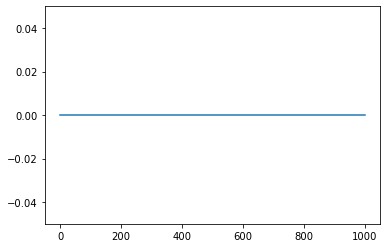

In [121]:
history = nn.epoch_loss_history
print(len(history))
plt.ylim((min(history)), (max(history)))
plt.plot(list(range(len(history))), history)
# plt.plot(list(range(epochs_to_do * len(features[0]))), history)
plt.show()

In [124]:
X_test, y_test = util.preprocess(X=testset.data, y=testset.targets, m=len(testset.data), n=len(testset.data[0])**2)
print(X_test.shape)

iteration = 0
print(y_test[iteration])
predictions = nn.predict(X_test)
# predictions_encoded = util.encode_probabilities(prediction)

print(util.encode_probabilities(predictions[iteration]))

(10000, 784)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Length of new_batch_size 10000
Shape of z is (784, 10000)
Shape of a is (784, 10000)
Shape of z is (784, 10000)
Shape of a is (784, 10000)
Shape of z is (10, 10000)
Shape of a is (10, 10000)
Length of hx 10
Shape of hx (10, 10000)
[1. 0. 0. ... 0. 0. 0.]


In [126]:
for i in range(len(X_test)):
    print(f"Test[i] sum is {np.sum(X_test[i])}")
    print(util.decode(util.encode_probabilities(predictions[i])), end=" vs ")
    print(util.decode(y_test[i]))

Test[i] sum is 18454
0 vs 7
Test[i] sum is 28850
0 vs 2
Test[i] sum is 9871
0 vs 1
Test[i] sum is 37014
0 vs 0
Test[i] sum is 19237
0 vs 4
Test[i] sum is 13855
0 vs 1
Test[i] sum is 21184
0 vs 4
Test[i] sum is 21062
0 vs 9
Test[i] sum is 30734
0 vs 5
Test[i] sum is 31350
0 vs 9
Test[i] sum is 29761


IndexError: index 10 is out of bounds for axis 0 with size 10